In [1]:
import math
import pandas as pd
import numpy as np
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
import warnings
import sys, os
warnings.filterwarnings('ignore')
%pylab inline

In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\baasi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define function to input a unique ID for the plate appearance
def pa_id_apply(df):
    # Get number of rows
    n_row = len(df.pitch_type)
    
    # Initialize list of plate appearances
    pa_ids = [1 for i in range(n_row)]
    
    # We know an at bat ends when the events column is not blank
    # In this case, the events column is a string
    # When it is blank, the events column has a float
    
    for i in range(1,n_row):
        if type(df.events[i]) == float:
            pa_ids[i] = pa_ids[i-1]
        else:
            pa_ids[i] = pa_ids[i-1] + 1
    
    # Add to dataframe
    df['pa_id'] = pa_ids            
    return df

# Define a function to calculate which pitch in the plate appearance it is
def pitch_in_pa_apply(df):
    # How many at bats are in the dataset
    total_pas = max(df.pa_id)
    
    in_pa_list = []
    
    # Loop through each PA and add in the pitch number in the AB
    for j in range(1,total_pas+1):
        pitches_in_ab = len(df[df.pa_id == j])
        
        for k in reversed(range(1,pitches_in_ab+1)):
            in_pa_list.append(k)
    
    df['pitch_in_pa'] = in_pa_list
    return df

# Define a function to determine the previous pitch
def previous_pitch(df,pa_id,pitch_in_pa):
    # If it is the first pitch of the plate appearance, then we don't have a previous pitch so return None
    if pitch_in_pa == 1:
        return None
    # Otherwise we return the Pitch type prior
    # We have to do -2 not -1 because pitch numbers start indexing from 1 and the dataframe indexes from 0
    else:
        return df[df.pa_id == pa_id][::-1].reset_index().pitch_name[pitch_in_pa - 2]

# Define a single function to perform the above functions on the dataset    
def enhance_df(df):
    df = pa_id_apply(df)
    df = pitch_in_pa_apply(df)
    df['prev_pitch'] = df.apply(lambda row: previous_pitch(df,row.pa_id,row.pitch_in_pa),axis = 1)
    
    whiffs = ['swinging_strike','missed_bunt','swinging_strike_blocked']
    df['whiff'] = df.apply(lambda row: 1 if row.description in whiffs else 0, axis = 1)
    return df

# One function to do all of the above
def final_df(first_name,last_name,start_date = '2018-01-01',end_date = '2020-12-31'):
    # Determine whether or not the player exists
    try:
        player_ids = playerid_lookup(last_name,first_name)['key_mlbam']
        # We have to add in this if clause for players with multiple entries
        # For example, Trevor Bauer's first ID is -1
        if player_ids[0] <= 0:
            player_id = player_ids[1]
        else:
            player_id = player_ids[0]
    except:
        return print("This player does not exist in the specified time range")
    
    pitch_by_pitch = statcast_pitcher(start_date, end_date, player_id)
    
    if len(pitch_by_pitch.index) == 0:
        return print('The pitcher did not pitch in the specified range of dates.')
    
    df = enhance_df(pitch_by_pitch)
    return df

In [3]:
bauer_stats = final_df('Trevor','Bauer')

Gathering player lookup table. This may take a moment.
Gathering Player Data


In [4]:
# Define a function to produce tables about a pitcher's sequences
def sequence_tables(df):
    # This pivot table gives us the number of times the pitcher uses the sequence
    print("Count of Combinations of Pitches")

    pivot1 = df.pivot_table(index = 'pitch_name', columns = 'prev_pitch',values = 'pitch_in_pa', aggfunc = 'count')
    pivot1.index = pivot1.index.rename('Pitch')
    pivot1 = pivot1.rename_axis("Previous Pitch", axis="columns")
    pivot1 = pivot1.replace(np.nan, '', regex=True)
    display(pivot1.style.set_precision(3))

    # This pivot table gives us the average exit velo on the second pitch of the sequence
    print("Exit Velo based on Previous Pitch")

    pivot2 = df.pivot_table(index = 'pitch_name', columns = 'prev_pitch',values = 'launch_speed', aggfunc = 'mean')
    pivot2.index = pivot2.index.rename('Pitch')
    pivot2 = pivot2.rename_axis("Previous Pitch", axis="columns")
    pivot2 = pivot2.replace(np.nan, '', regex=True)
    display(pivot2.style.set_precision(3))

    # This pivot table gives us the whiff rate on the second pitch of the sequence
    print("Whiff Rate based on Previous Pitch")

    pivot3 = df.pivot_table(index = 'pitch_name', columns = 'prev_pitch',values = 'whiff', aggfunc = 'mean')
    pivot3.index = pivot3.index.rename('Pitch')
    pivot3 = pivot3.rename_axis("Previous Pitch", axis="columns")
    pivot3 = pivot3.replace(np.nan, '', regex=True)
    display(pivot3.style.set_precision(3))
    
    # The next step to this is to make it such that the user can choose the stat they want the pivot table for
    return None

# Define a function to do it from start to finish
def full_sequence(first_name,last_name,start_date = '2018-01-01',end_date = '2020-12-31'):
    df = final_df(first_name,last_name,start_date,end_date)
    sequence_tables(df)
    return None

In [5]:
sequence_tables(bauer_stats)

Count of Combinations of Pitches


Previous Pitch,2-Seam Fastball,4-Seam Fastball,Changeup,Cutter,Knuckle Curve,Sinker,Slider
Pitch,,,,,,,
2-Seam Fastball,19,62,16,47,66,,78
4-Seam Fastball,37,944,149,319,363,21,224
Changeup,14,149,70,36,73,,20
Cutter,18,378,47,224,109,8,27
Knuckle Curve,16,446,70,187,504,8,118
Sinker,,29,,6,9,15,11
Slider,37,288,30,139,200,5,286


Exit Velo based on Previous Pitch


Previous Pitch,2-Seam Fastball,4-Seam Fastball,Changeup,Cutter,Knuckle Curve,Sinker,Slider
Pitch,,,,,,,
2-Seam Fastball,93.6,89.3,94.1,88.9,88.1,,87
4-Seam Fastball,92.1,90.1,89.6,89.2,88.3,78.2,87.8
Changeup,91.1,88,93,89.7,84.3,,82.1
Cutter,80,84.6,77.4,83.5,83.5,95.7,89.2
Knuckle Curve,,87.5,89.4,89.4,84.7,64.5,87.7
Sinker,,82.7,,96.5,85.3,90,84.6
Slider,81,82.4,91.6,77,80,90.1,75.8


Whiff Rate based on Previous Pitch


Previous Pitch,2-Seam Fastball,4-Seam Fastball,Changeup,Cutter,Knuckle Curve,Sinker,Slider
Pitch,,,,,,,
2-Seam Fastball,0.0526,0.0645,0.0625,0.0851,0.0909,,0.0256
4-Seam Fastball,0.135,0.0985,0.047,0.0972,0.102,0.19,0.0982
Changeup,0.143,0.141,0.129,0.167,0.123,,0.15
Cutter,0.222,0.153,0.191,0.174,0.211,0.25,0.148
Knuckle Curve,0.25,0.135,0.0857,0.187,0.187,0,0.161
Sinker,,0.138,,0,0.111,0.0667,0
Slider,0.216,0.184,0.133,0.237,0.225,0.2,0.182


In [6]:
# Define function to produce key stats and plots for a given sequence
def specific_sequence(df,pitch1,pitch2,batter_handedness = ['L','R']):
    pitcher_name = df.player_name.unique()[0]
    
    # Pitch Profiles
    profiles = df.groupby('pitch_name').mean()[['release_speed',\
                                                    'release_spin_rate','pfx_x','pfx_z','whiff','launch_speed','launch_angle']]
    profiles = profiles.rename(columns = {'release_speed':'Pitch Velocity',
                               'release_spin_rate':'Spin Rate',
                               'pfx_x':'Horizontal Movement',
                               'pfx_z':'Vertical Movement',
                               'whiff':'Whiff Rate',
                               'launch_speed':'Exit Velocity',
                               'launch_angle':'Launch Angle'})
    profiles = profiles[profiles.index.isin([pitch1,pitch2])]
    
    print('Pitch Profiles for '+ pitcher_name + "'s " + pitch1 + ' and ' + pitch2)
    display(profiles)
    
    # Combination Statistics    
    df = df[df.stand.isin(batter_handedness)]
    df_combo = df[(df.prev_pitch == pitch1) & (df.pitch_name == pitch2)]
    
    # Basic Stats
    uses = len(df_combo.index)
    
    print('This combination was used ' + str(uses) + " times in the selected time frame by " + pitcher_name)
    
    hits = ['double','single','triple','home_run']
    reach_base = hits + ['walk','hit_by_pitch']
    at_bats = ['double', 'double_play', 'field_error', 'field_out', 'fielders_choice',
                   'fielders_choice_out', 'force_out', 'grounded_into_double_play',
                   'home_run', 'pickoff_1b', 'single', 'strikeout',
                   'strikeout_double_play', 'triple']
    obp_denoms = at_bats + ['walk','hit_by_pitch','sac_fly']
    
    singles = len(df_combo[df.events == 'single'].index)
    doubles = len(df_combo[df.events == 'double'].index)
    triples = len(df_combo[df.events == 'triple'].index)
    hrs = len(df_combo[df_combo.events == 'home_run'].index)
    
    ba = len(df_combo[df_combo.events.isin(hits)].index)/len(df_combo[df_combo.events.isin(at_bats)].index)
    obp = len(df_combo[df_combo.events.isin(reach_base)].index)/len(df_combo[df_combo.events.isin(obp_denoms)].index)
    slg = (singles + 2*doubles + 3*triples + 4*hrs)/len(df_combo[df_combo.events.isin(at_bats)].index)
    ops = obp + slg
    
    d = {'BA': [ba], 'OBP': [obp], 'SLG': [slg], 'OPS':[ops]}
    stats = pd.DataFrame(data=d)
    print("Basic Stats for the " + pitch1 + "-" + pitch2 + " Sequence from " + pitcher_name)
    display(stats)
    
    # Advanced Stats
    whiff_rate = df_combo.whiff.mean()
    launch_angle = df_combo.launch_angle.mean()
    exit_velo = df_combo.launch_speed.mean()
    wOBA_against = df_combo.woba_value.mean()
    babip = df_combo.babip_value.mean()
    
    # Batted Ball Types
    batted_balls = df_combo.groupby('bb_type').count().pitch_type
    count = batted_balls.sum()
    
    # We need to account for if a certain batted ball type hasn't occured against the combo
    bb_types = ['ground_ball','fly_ball','line_drive','popup']
    for j in bb_types:
        if j not in list(batted_balls.index):
            batted_balls.loc[j] = 0
    
    gb_pct = batted_balls['ground_ball']/count
    fb_pct = batted_balls['fly_ball']/count
    ld_pct = batted_balls['line_drive']/count
    pu_pct = batted_balls['popup']/count
    
    d2 = {'BABIP':[babip],'Whiff Rate':[whiff_rate],'Launch Angle':[launch_angle],'Exit Velo':[exit_velo],\
              'wOBA Against': [wOBA_against],'GB%':[gb_pct],'FB%':[fb_pct],'LD%':[ld_pct],'PO%':[pu_pct]}
    astats = pd.DataFrame(data=d2)
    print("Advanced Stats for the " + pitch1 + "-" + pitch2 + " Sequence from " + pitcher_name)
    display(astats)
    
    # Plots of Pitch Locations
    pitch1_index = list(df_combo.index + 1)
    df_p1 = df[df.index.isin(pitch1_index)]
    df_p1['sequence_spot'] = "First Pitch"
    df_combo['sequence_spot'] = "Second Pitch"
    df_plot = pd.concat([df_combo,df_p1])
    
    plot_title = pitcher_name + " Pitch Location for Sequence (Catcher's POV)"
    
    plocs = ggplot(df_plot,aes(x = 'plate_x', y = 'plate_z', color = 'pitch_name')) + geom_point()\
                + geom_segment(aes(x = .75, y = 1.5, xend = .75, yend = 3.5), color = 'black')\
                + geom_segment(aes(x = -.75, y = 1.5, xend = -.75, yend = 3.5), color = 'black')\
                + geom_segment(aes(x = -.75, y = 1.5, xend = .75, yend = 1.5), color = 'black')\
                + geom_segment(aes(x = -.75, y = 3.5, xend = .75, yend = 3.5), color = 'black')\
                + facet_wrap('~sequence_spot')\
                + labs(title = plot_title, x = 'Pitch Side', y='Pitch Height',color = 'Pitch')
    display(plocs)
    
    return df_plot

# Define a function to do sequence analysis from start to finish
def full_sequence(first_name,last_name,pitch1,pitch2,start_date = '2018-01-01',end_date = '2020-12-31',batter_handedness = ['L','R']):
    df = final_df(first_name,last_name,start_date,end_date)
    df_final = specific_sequence(df,pitch1,pitch2,batter_handedness)
    return df_final

Pitch Profiles for Trevor Bauer's Changeup and Cutter


,Pitch Velocity,Spin Rate,Horizontal Movement,Vertical Movement,Whiff Rate,Exit Velocity,Launch Angle
pitch_name,,,,,,,
Changeup,86.377823,1760.478351,-1.291581,0.678234,0.131417,86.993506,2.506494
Cutter,85.227474,2704.510460,0.463072,-0.080870,0.163823,84.720526,18.489474


This combination was used 47 times in the selected time frame by Trevor Bauer
Basic Stats for the Changeup-Cutter Sequence from Trevor Bauer


,BA,OBP,SLG,OPS
0,0.25,0.4,0.25,0.65


Advanced Stats for the Changeup-Cutter Sequence from Trevor Bauer


,BABIP,Whiff Rate,Launch Angle,Exit Velo,wOBA Against,GB%,FB%,LD%,PO%
0,0.2,0.191489,38.0,77.36,0.32,0.0,0.2,0.4,0.4


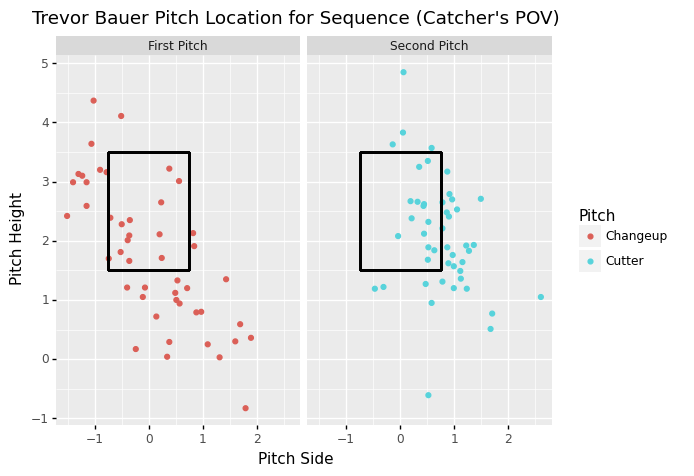

<ggplot: (-9223371866436610380)>

In [7]:
df = specific_sequence(bauer_stats,'Changeup','Cutter')

#### Self-Scouting
From this analysis of Trevor Bauer, we are intrigued by his Changeup-Cutter sequence. The reason that this is intriguing is that is produces a 19.1% Whiff Rate and a 77.4 mph average exit velocity from hitters. On average, Bauer's cutter produces a 16.4% whiff rate and 84.7 mph average exit velocity. We will throw out the average exit velocity number because we can see that there have been just 5 batted balls against the combination. However, despite this whiff rate and these results, Bauer has used the combination just 47 times in the past 3 seasons. A further deep dive will show that he did not use the combination at all in 2020, his Cy Young season.

For a combination which increases the Whiff Rate on his cutter by 2.7%, one would think that he should use the pitch sequence more. We can also see that the reason these pitches work well together are because they are thrown at similar speeds but ove in opposite directions horizontally. We see below that Bauer's cutter and slider move similarly, with the slider being a little slower and having more horizontal movement. We also notice that his slider is more effective than his current, producing a higher whiff rate and lower exit velocity. The Changeup-Slider combination may also be effective and we can see that in a small sample size (only 30 occurences) it has not produced exceptional Whiff Rates or Exit Velocity, however testing from the Changeup-Cutter combination may inform us that there is more positive regression to come from the Changeup-Slider combination.

In [8]:
# Pitch Profiles for Bauer's Slider and Cutter
pitch1 = 'Slider'
pitch2 = 'Cutter'
profiles = bauer_stats.groupby('pitch_name').mean()[['release_speed',\
                                                    'release_spin_rate','pfx_x','pfx_z','whiff','launch_speed','launch_angle']]
profiles = profiles.rename(columns = {'release_speed':'Pitch Velocity',
                               'release_spin_rate':'Spin Rate',
                               'pfx_x':'Horizontal Movement',
                               'pfx_z':'Vertical Movement',
                               'whiff':'Whiff Rate',
                               'launch_speed':'Exit Velocity',
                               'launch_angle':'Launch Angle'})
profiles = profiles[profiles.index.isin([pitch1,pitch2])]
    
print("Pitch Profiles for Trevor Bauers's " + pitch1 + ' and ' + pitch2)
display(profiles)

Pitch Profiles for Trevor Bauers's Slider and Cutter


,Pitch Velocity,Spin Rate,Horizontal Movement,Vertical Movement,Whiff Rate,Exit Velocity,Launch Angle
pitch_name,,,,,,,
Cutter,85.227474,2704.510460,0.463072,-0.080870,0.163823,84.720526,18.489474
Slider,80.634318,2753.552056,1.405334,-0.175604,0.192007,79.640278,18.148148


Pitch Profiles for Trevor Bauer's Changeup and Slider


,Pitch Velocity,Spin Rate,Horizontal Movement,Vertical Movement,Whiff Rate,Exit Velocity,Launch Angle
pitch_name,,,,,,,
Changeup,86.377823,1760.478351,-1.291581,0.678234,0.131417,86.993506,2.506494
Slider,80.634318,2753.552056,1.405334,-0.175604,0.192007,79.640278,18.148148


This combination was used 30 times in the selected time frame by Trevor Bauer
Basic Stats for the Changeup-Slider Sequence from Trevor Bauer


,BA,OBP,SLG,OPS
0,0.2,0.272727,0.7,0.972727


Advanced Stats for the Changeup-Slider Sequence from Trevor Bauer


,BABIP,Whiff Rate,Launch Angle,Exit Velo,wOBA Against,GB%,FB%,LD%,PO%
0,0.090909,0.133333,25.6,91.58,0.390909,0.2,0.6,0.2,0.0


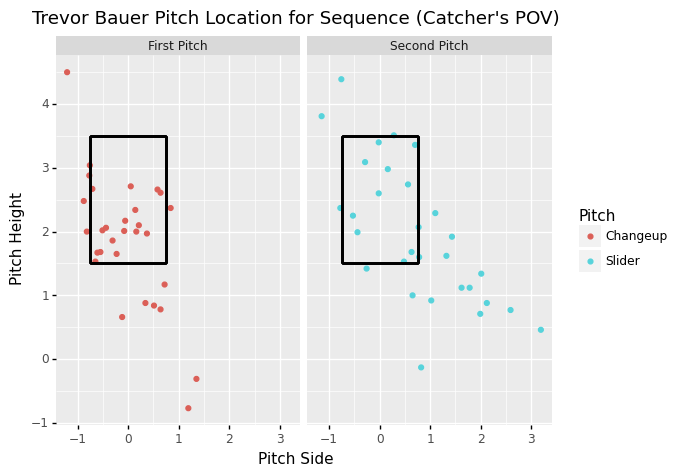

<ggplot: (-9223371866440313336)>

In [9]:
df2 = specific_sequence(bauer_stats,'Changeup','Slider')

#### Advance Scouting
For someone facing Trevor Bauer, they can see that his favorite pitch to throw off of his Knuckle Curve is a second Knuckle Curve as that combination appeared 504 time in the past three years, far more than any other combination that his Knuckle Curve is used to set up, specifically the next closes is the Knuckle Curve-4 Seam Fastball combination with just 363 total uses in the same time frame. Below I have printed the results for Bauer's Knucle Curve-Knuckle Curve combination. We see that it results in a miniscule .1714 wOBA against along with producing a massive ground ball rate of 77.27%. Additionally, from the plots of the pitches, we can see that the second Knuckle Curve is often farther out of the strike zone, down and away to right-handed batters and down and inside to left-handed batters. This means that even if you know the second one is coming, you should not be prepared to swing.

As a result, we can say that if Bauer throws a batter a Knuckle Curve, we can anticipate than any follow-up Knuckle Curve will be down in the strike zone. Depending on a batter's preferred approach, they can sit on that second Knuckle Curve, or anticipate that it will be a ball and sit on his 4 Seam Fastball which is his next likeliest pitch to throw.

Pitch Profiles for Trevor Bauer's Knuckle Curve and Knuckle Curve


,Pitch Velocity,Spin Rate,Horizontal Movement,Vertical Movement,Whiff Rate,Exit Velocity,Launch Angle
pitch_name,,,,,,,
Knuckle Curve,79.186485,2615.845287,0.69489,-1.55083,0.144635,87.181858,-1.809735


This combination was used 504 times in the selected time frame by Trevor Bauer
Basic Stats for the Knuckle Curve-Knuckle Curve Sequence from Trevor Bauer


,BA,OBP,SLG,OPS
0,0.148438,0.161538,0.195312,0.356851


Advanced Stats for the Knuckle Curve-Knuckle Curve Sequence from Trevor Bauer


,BABIP,Whiff Rate,Launch Angle,Exit Velo,wOBA Against,GB%,FB%,LD%,PO%
0,0.137405,0.186508,-6.794521,84.720548,0.171374,0.772727,0.045455,0.166667,0.015152


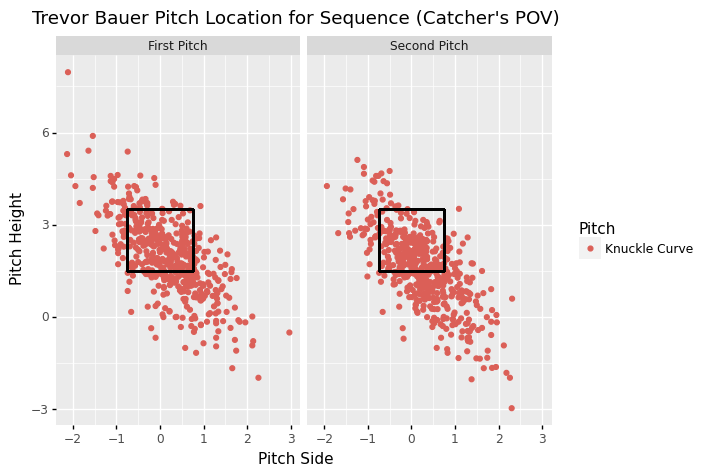

<ggplot: (-9223371866433572440)>

In [10]:
df3 = specific_sequence(bauer_stats,'Knuckle Curve','Knuckle Curve')

Let's see how predictive pitch sequencing results are to future years

In [11]:
# Let's read in all MLB player IDs in history
# Gotten from Baseball Prospectus here: https://github.com/chadwickbureau/register

url = 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people.csv'
all_ids = pd.read_csv(url, error_bad_lines=False)
print('We have read in ' + str(len(all_ids.index)) + ' rows')

# We want to remove all players who do not have an mlbam id
all_ids = all_ids[all_ids['key_mlbam'].notna()]

# Next we want to remove everybody whose last game came prior to 2015 (start of Statcast era)
# Actually we need players on both sides of our regression
# Since we will use 2015-2018 as our early period and try to predict the 2019-2020 period
# Everybody in the dataset much have at least played in 2019
all_ids = all_ids[all_ids.mlb_played_last >= 2019]
print('We have cut it down to ' + str(len(all_ids.index)) + ' rows')

# Ideally we need a way to get it down to just pitchers

We have read in 375016 rows
We have cut it down to 1671 rows


In [12]:
# We can modify our dataframe function to take in key_mlbam which will skip a step and make the code faster
def df_production(player_id,start_date,end_date):
    pitch_by_pitch = statcast_pitcher(start_date, end_date, player_id)
    
    if len(pitch_by_pitch.index) == 0:
        return None
    
    df = enhance_df(pitch_by_pitch)
    return df

# We want to create a dataframe with the following columns
# player_id, pitch 1 in sequence, pitch 2 in sequence, # of uses, total batted balls, 
# exit velo against, exit velo reduced, whiff rate, whiff rate added

column_names = ['player_id',
                'pitch1',
                'pitch2',
                'uses',
                'tot_bb',
                'exit_velo',
                'exit_velo_minus',
                'whiff_rate',
                'whiff_rate_add']

early_data = pd.DataFrame(columns = column_names)
late_data = pd.DataFrame(columns = column_names)

# Define a function to extract the necessary values for our table
def row_add(df,pitch1,pitch2):    
    # Get base stats for the second pitch to calculate exit velo reduced and whiff rate added
    base_exit_velo = df[df.pitch_name == pitch2].launch_speed.mean()
    base_whiff_rate = df[(df.pitch_name == pitch2) & (df.prev_pitch != pitch1)].whiff.mean()
    
    # Get the dataset of just our sequence
    df_comb = df[(df.pitch_name == pitch2) & (df.prev_pitch == pitch1)]
    
    # Calculate our statistics
    uses = len(df_comb.index)
    tot_bb = df_comb.groupby('bb_type').count().pitch_type.sum()
    exit_velo = df_comb.launch_speed.mean()
    exit_velo_reduced = base_exit_velo - exit_velo
    whiff_rate = df_comb.whiff.mean()
    whiff_rate_added = whiff_rate - base_whiff_rate
    
    # Return our statistics
    return uses,tot_bb,exit_velo,exit_velo_reduced,whiff_rate,whiff_rate_added

In [ ]:
# THIS CELL IS A SCRAPER
# IT SCRAPES AND TRANSFORMS A LARGE QUANTITY OF DATA USING MULTIPLE REQUESTS
# IT WILL TAKE ~3 HOURS TO RUN, THE CSVs IT PRODUCES CAN BE FOUND HERE: https://github.com/baasilebrahim/pitch-sequencing

# Let's create our dataframes

# Functions to enable and disable print since statcast_pitchers has a print statement built in
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__
    
print('Starting Scrape')

# Start blocking printing
blockPrint()

# First we create our dataframe of old data which we will try to use to predict new data
for i in all_ids.key_mlbam:
    # Get initial dataframe in time range for a given pitcher
    df_hold = df_production(int(i),'2015-01-01','2018-12-31');
    # The df_hold will be NoneType if the player has never pitched
    # So we only want to proceed if it is not a NoneType
    if df_hold is not None:
        # Get specific list of pitches the pitcher throws
        pitches = list(df_hold.pitch_name.unique())
        pitches = [x for x in pitches if str(x) != 'nan']
        # Loop through all possible combinations of pitches and get the metrics
        for j in pitches:
            for k in pitches:
                uses,tot_bb,exit_velo,exit_velo_reduced,whiff_rate,whiff_rate_added = row_add(df_hold,j,k)
                early_data = early_data.append({'player_id': int(i),
                                                'pitch1': j,
                                                'pitch2': k,
                                                'uses': uses,
                                                'tot_bb': tot_bb,
                                                'exit_velo': exit_velo,
                                                'exit_velo_minus': exit_velo_reduced,
                                                'whiff_rate': whiff_rate,
                                                'whiff_rate_add': whiff_rate_added},ignore_index=True)

# Next, we create our new data
for i in all_ids.key_mlbam:
    # Get initial dataframe in time range for a given MLB player
    df_hold = df_production(int(i),'2019-01-01','2020-12-31');
    # The df_hold will be NoneType if the player has never pitched
    # So we only want to proceed if it is not a NoneType
    if df_hold is not None:
        # Get specific list of ptiches the pitcher throws
        pitches = list(df_hold.pitch_name.unique())
        pitches = [x for x in pitches if str(x) != 'nan']
        # Loop through all possible combinations of pitches and get the metrics
        for j in pitches:
            for k in pitches:
                uses,tot_bb,exit_velo,exit_velo_reduced,whiff_rate,whiff_rate_added = row_add(df_hold,j,k)
                late_data = late_data.append({'player_id': int(i),
                                                'pitch1': j,
                                                'pitch2': k,
                                                'uses': uses,
                                                'tot_bb': tot_bb,
                                                'exit_velo': exit_velo,
                                                'exit_velo_minus': exit_velo_reduced,
                                                'whiff_rate': whiff_rate,
                                                'whiff_rate_add': whiff_rate_added},ignore_index=True)

# Reenable printing
enablePrint()

print('Scrape Complete')

# Let's send these dataframes to CSV files so that if we ever decide to use this code in the future
# we don't have to pull the data again

early_data.to_csv('early_data.csv')
late_data.to_csv('late_data.csv')

# They can be found here: https://github.com/baasilebrahim/pitch-sequencing

In [13]:
# You can find the CSVs here: https://github.com/baasilebrahim/pitch-sequencing

# Read in Early Data from Github
ed_url = 'https://raw.githubusercontent.com/baasilebrahim/pitch-sequencing/main/early_data.csv'
early_data = pd.read_csv(ed_url, error_bad_lines=False).drop(['Unnamed: 0'],axis = 1)

# Read in Late Data from Github
ld_url = 'https://raw.githubusercontent.com/baasilebrahim/pitch-sequencing/main/late_data.csv'
late_data = pd.read_csv(ld_url, error_bad_lines=False).drop(['Unnamed: 0'],axis = 1)

# Let's remove combinations where there are zero uses
ldp = late_data[~(late_data['uses'] == 0)]
edp = early_data[~(early_data['uses'] == 0)]

#I want to get the usage pct as we are comparing over different numbers of years
def usage_pct_add(df,key_mlbam,uses):
    total = df[df.player_id == key_mlbam].uses.sum()
    return uses/total

# Apply usage percentage function
edp['use_pct'] = edp.apply(lambda row: usage_pct_add(edp,row.player_id,row.uses), axis = 1)
ldp['use_pct'] = ldp.apply(lambda row: usage_pct_add(ldp,row.player_id,row.uses), axis = 1)

# Let's get unique combination ids such that we can match stats across time ranges
edp['comb_id'] = edp.pitch1 + edp.pitch2 + edp.player_id.astype(str)
ldp['comb_id'] = ldp.pitch1 + ldp.pitch2 + ldp.player_id.astype(str)

# We only want to keep combinations that exist in both the early and late dataset
edp_mod = edp[edp.comb_id.isin(ldp.comb_id.unique())]
ldp_mod = ldp[ldp.comb_id.isin(edp.comb_id.unique())]

# Let's make a larger database with everything
# We will merge on the combination ID so that we can have all the stats for that combo in a row
# Column labels with _x will be from the early period and _y from the late
complete = pd.merge(edp_mod,ldp_mod,on='comb_id',how='outer')

In [14]:
# Let's establish a minimum number of uses for the combo
comb_min = 50
mod_data = complete[(complete.uses_x >= comb_min) & (complete.uses_y >= comb_min)]

# We know that the correlation table will add in unnecessary columns
# We use this to prepare the columns and rows to be dropped
dropx = ['player_id_x','uses_x','tot_bb_x','exit_velo_y',
         'exit_velo_minus_y','whiff_rate_y','whiff_rate_add_y',
         'use_pct_y','player_id_y','uses_y','tot_bb_y']
dropy = ['player_id_x','uses_x','tot_bb_x','exit_velo_x',
         'exit_velo_minus_x','whiff_rate_x','whiff_rate_add_x',
         'use_pct_x','player_id_y','uses_y','tot_bb_y']

# Produce correlation plot
corr = mod_data.corr().drop(dropx).drop(dropy,axis=1)
corr.style.background_gradient(cmap='coolwarm',axis = None).set_precision(3)

,exit_velo_y,exit_velo_minus_y,whiff_rate_y,whiff_rate_add_y,use_pct_y
exit_velo_x,0.395,0.000921,-0.36,-0.0265,0.0841
exit_velo_minus_x,-0.0193,0.0173,-0.00198,0.0221,-0.00766
whiff_rate_x,-0.406,0.0116,0.714,0.0788,0.018
whiff_rate_add_x,-0.0929,0.0602,0.164,0.16,0.0614
use_pct_x,0.107,0.0111,-0.0753,0.0604,0.835


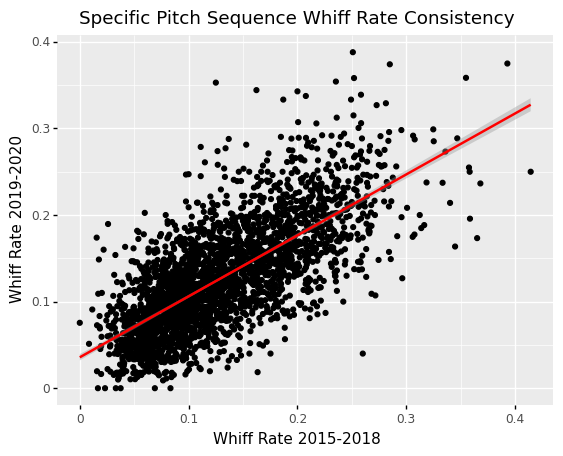

<ggplot: (-9223371866431645560)>

In [15]:
# Based on the Whiff Rate correlation, we can plot that and visualize the correlation

ggplot(mod_data, aes(x='whiff_rate_x',y='whiff_rate_y'))\
    + geom_point() + geom_smooth(color = 'red')\
    + xlab("Whiff Rate 2015-2018") + ylab("Whiff Rate 2019-2020")\
    + ggtitle("Specific Pitch Sequence Whiff Rate Consistency")

In [16]:
# Let's try a regression
# R style functions provide a more comprehensive output so we will use that

mod1 = smf.ols('whiff_rate_y ~ whiff_rate_x', data = mod_data).fit()
mod1.summary()

# We can observe faily strong preditive value with highly significant variables
# Since we are not comparing different models, we do not need to train/test and comapre RMSEs
# on out of training sample data.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           whiff_rate_y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     2891.
Date:                Mon, 15 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:19:07   Log-Likelihood:                 4775.1
No. Observations:                2780   AIC:                            -9546.
Df Residuals:                    2778   BIC:                            -9534.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0357      0.002     19.117      0.000       0.032       0.039
whiff_rate_x     0.7041      0.013     53.766      0.000       0.678       0.730
==============================================================================
Omnibus:                      139.897   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.524
Skew:                           0.455   Prob(JB):                     1.74e-44
Kurtosis:                       3.954   Cond. No.                         16.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The last thing to consider is that there is still a small correlation for whiff rate added so much of the predictive value of whiff rates may actually be the result of the whiff rate of the second pitch in the sequence.

Consequently, using the high .835 correlation between usage rates in the first period of time and the second period of time to signify the consistency of sequence usage may be more important. Batters can use this to inform their approach to a pitcher as they can improve their understanding of how pitcheres use different pitches.